In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from importlib import reload
import curses    ####  pip install windows-curses

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import specsanalyzer
from specsanalyzer import SpecsAnalyzer



In [3]:
#reload(specsanalyzer)
spa = SpecsAnalyzer()

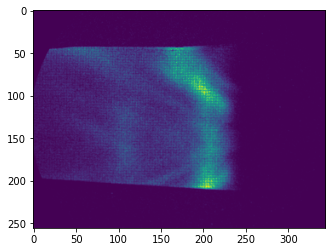

In [4]:
with open('../tests/data/dataEPFL/R9132/Data9132_RAWDATA.tsv') as file:
#with open('../tests/data/dataFHI/Scan1232.tsv') as file:
    tsv_data = np.loadtxt(file, delimiter='\t')
plt.figure()
plt.imshow(tsv_data)

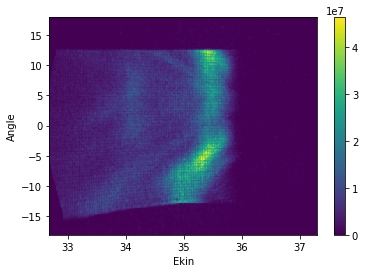

In [9]:
# Testing convert and crop on the imported data
spa = SpecsAnalyzer(config="../tests/data/dataEPFL/config/config.yaml")

lens_mode="WideAngleMode"
kinetic_energy=35.0
pass_energy=35.0

res_xarray = spa.convert_image(tsv_data, pass_energy, kinetic_energy, lens_mode)
plt.figure()
res_xarray.plot(cmap='viridis',vmin=0)

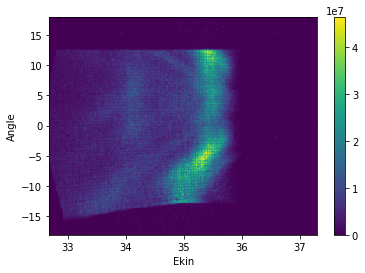

In [12]:
with open('../tests/data/dataEPFL/R9132/Data9132_IGOR_corrected.tsv') as file:
#with open('../tests/data/dataFHI/Scan1232_converted.tsv') as file:
    ref_data = np.loadtxt(file, delimiter='\t')
    ref_data = ref_data
    #ref_data = ref_data.T
#angle_axis = np.linspace(-18, 17.3077, ref_data.shape[0])
#angle_axis = np.linspace(-18, 17.3077, ref_data.shape[0])

#ek_axis = np.linspace(15.86, 21.1247, ref_data.shape[1])
#ek_axis = np.linspace(33.85, 37.1404, ref_data.shape[1])


import specsanalyzer.convert
#reload(specsanalyzer.convert)   
#let's get all the functions to be tested
from specsanalyzer.convert import get_damatrix_fromcalib2d
from specsanalyzer.convert import get_rr_da
from specsanalyzer.convert import calculate_polynomial_coef_da
from specsanalyzer.convert import mcp_position_mm
from specsanalyzer.convert import calculate_matrix_correction

spa = SpecsAnalyzer(config="../tests/data/dataEPFL/config/config.yaml")
config_dict=spa.config
lens_mode="WideAngleMode"
kinetic_energy=35
pass_energy=35
binning=4

(ek_axis,
    angle_axis,
    angular_correction_matrix,
    e_correction,
    jacobian_determinant,
) = calculate_matrix_correction(
    lens_mode,
    pass_energy,
    kinetic_energy,
    binning,
    config_dict,
)


ref_xarray = xr.DataArray(
    data=ref_data,
    coords={"Angle": angle_axis, "Ekin": ek_axis},
    dims=["Angle", "Ekin"],
)
plt.figure()
ref_xarray.plot()

In [13]:
#ref_xarray_reint=ref_xarray.interp_like(res_xarray)
#ff_xarray = (res_xarray - ref_xarray_reint)/

normalization=np.abs((ref_xarray.to_numpy())).mean()

#ff_xarray = (res_xarray - ref_xarray)/normalization
ff_xarray = (res_xarray - ref_xarray)/ref_xarray

np.abs((ff_xarray.to_numpy())).sum()

nan

Text(0.5, 1.0, 'Difference/Mean pixel intensity')

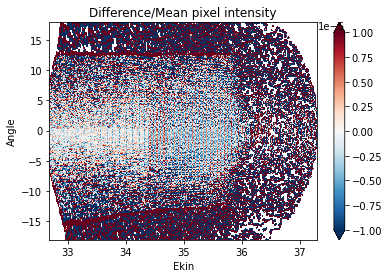

In [14]:
plt.figure()
ff_xarray.plot(cmap='RdBu_r',vmax=1e-5 )
plt.title("Difference/Mean pixel intensity")

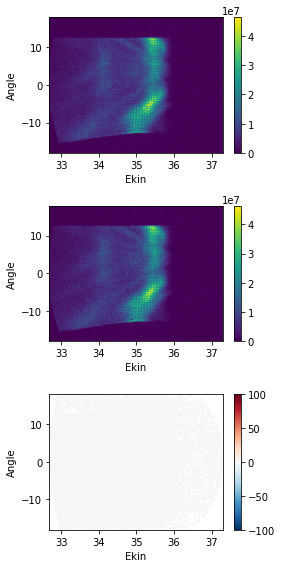

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(4, 8))
subplot1=ref_xarray.plot(ax=ax1,cmap='viridis',vmin=0 )
subplot2=res_xarray.plot(ax=ax2,cmap='viridis',vmin=0)
subplot3=ff_xarray.plot(cmap='RdBu_r',ax=ax3,vmax=100 )

plt.tight_layout()



In [16]:

lens_mode="WideAngleMode"
kinetic_energy=35.0
pass_energy=35.0

%timeit res_xarray = spa.convert_image(tsv_data, pass_energy, kinetic_energy, lens_mode)

60.1 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
convert1 = specsanalyzer.convert.physical_unit_data_1(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
        )

13.7 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
convert1 = specsanalyzer.convert.physical_unit_data_1(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
        )

In [19]:
%%timeit
convert2 = specsanalyzer.convert.physical_unit_data_2(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
        )

1.4 s ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
convert2 = specsanalyzer.convert.physical_unit_data_2(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
        )

In [22]:
np.testing.assert_allclose(convert1, convert2)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 1 / 88064 (0.00114%)
Max absolute difference: 96425.51913512
Max relative difference: 1.
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...

In [23]:
%%timeit
convert3 = specsanalyzer.convert.physical_unit_data_3(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           ek_axis,
           angle_axis
        )

/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python

58.2 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python

In [24]:
convert3 = specsanalyzer.convert.physical_unit_data_3(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           ek_axis,
           angle_axis
        )

/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python3.8/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/mnt/pcshare/users/Laurenz/AreaB/specsanalyzer/.pyenv/lib/python

In [25]:
np.testing.assert_allclose(convert1, convert3)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

x and y nan location mismatch:
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],...

In [26]:
%%timeit
convert5 = specsanalyzer.convert.physical_unit_data_5(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           angle_axis,
           ek_axis
        )

4.1 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
convert5 = specsanalyzer.convert.physical_unit_data_5(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           angle_axis,
           ek_axis
        )

In [28]:
np.testing.assert_allclose(convert1, convert5)

In [29]:
%%timeit
convert6 = specsanalyzer.convert.physical_unit_data_6(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           angle_axis,
           ek_axis
        )

13.3 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
convert6 = specsanalyzer.convert.physical_unit_data_6(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           angle_axis,
           ek_axis
        )

In [31]:
np.testing.assert_allclose(convert1, convert6)

In [32]:
%%timeit
convert7 = specsanalyzer.convert.physical_unit_data_7(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           angle_axis,
           ek_axis
        )

2.1 ms ± 498 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
convert7 = specsanalyzer.convert.physical_unit_data_7(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
           angle_axis,
           ek_axis
        )

In [34]:
np.testing.assert_allclose(convert1, convert7)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 3 / 88064 (0.00341%)
Max absolute difference: 101156.83123022
Max relative difference: 1.
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...

In [35]:
%%timeit
convert8 = specsanalyzer.convert.physical_unit_data_8(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
        )

348 ms ± 4.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
convert8 = specsanalyzer.convert.physical_unit_data_8(
           tsv_data,
           angular_correction_matrix,
           e_correction,
           jacobian_determinant,
        )

In [ ]:
np.testing.assert_allclose(convert1, convert8)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 1 / 88064 (0.00114%)
Max absolute difference: 96425.51913512
Max relative difference: 1.
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...

In [37]:
np.testing.assert_allclose(convert2, convert8)